In [1]:

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-08-30 23:18:23.262060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 23:18:24.256682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-30 23:18:25.454765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 23:18:25.586114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Num GPUs Available:  1


2023-08-30 23:18:25.671280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 23:18:25.671522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 23:18:25.671677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
train_data_dir = "data/dataSplit/train/"
test_data_dir = "data/dataSplit//test/"
validation_data_dir = "data/dataSplit/validation/"

IMG_HEIGHT = 197
IMG_WIDTH = 197
color='rgb'
#IMG_HEIGHT = 48
#IMG_WIDTH = 48
#color='grayscale'
input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
batch_size = 128
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#from compat.v1 import ConfigProto
#from compat.v1 import InteractiveSession
#from keras.layers import Resizing
#import tensorflow_hub as hub

#def fix_gpu():
#    config = ConfigProto()
#    config.gpu_options.allow_growth = True
#    session = InteractiveSession(config=config)
#    physical_devices = tf.config.list_physical_devices('GPU')
#    tf.config.set_visible_devices(physical_devices[0], 'GPU')

def prepare_data(dir, color='grayscale', aug=False):
    if aug:
        datagen = ImageDataGenerator(
                                rescale=1./255,
                                featurewise_center=False,
                                featurewise_std_normalization=False,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
        dir,
        color_mode=color,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
    axs[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    axs[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')

    fig.savefig('train.png')
    plt.show()

#fix_gpu()
train_generator = prepare_data(train_data_dir, color=color, aug=True)
test_generator = prepare_data(test_data_dir, color=color)
validation_generator = prepare_data(validation_data_dir, color=color)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


Create model

In [ ]:
# Original
"""
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
"""

#Baseline model 

In [ ]:
"""
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
"""

Five layer model from GOLD

In [ ]:
#import keras
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
"""
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Add the second convolutional layer
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Add the third convolutional layer
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten the tensor output from the convolutional layers
model.add(Flatten())

# Add the fully connected layer
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Add the output layer
model.add(Dense(7, activation='softmax')) # assuming 10 classes for CIFAR-10 dataset

# Configure the learning process
optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=0.0001)
model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
"""

resnet gold last

In [5]:
#https://github.com/amilkh/cs230-fer/blob/master/models/tf-ResNet50.ipynb

'''
I solved this issue by changing the import from
from keras.engine.topology import get_source_inputs
to
from keras.utils.layer_utils import get_source_inputs in keras_vggface/models.py.
'''
from keras_vggface.vggface import VGGFace
#from tensorflow.keras.engine import Model
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(input_shape[0], input_shape[1], 3), pooling='avg')

sgd = SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)


device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  model = Sequential()
  model.add(vgg_notop)
  model.add(Flatten(name='flatten'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(4096, activation='relu', name='fc6'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(1024, activation='relu', name='fc7'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(7, activation='softmax', name='classifier'))

  batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]

  for i in range(FROZEN_LAYER_NUM):
      if i not in batch_norm_indices:
          model.layers[0].layers[i].trainable = False
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

94694792/94694792 [==============================] - 48s 1us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#Pentru cazul in care vrem sa incarcam un model deja antrenat

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/last.h5')
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model

Epoch 1/49
225/225 [==============================] - 267s 1s/step - loss: 0.6623 - accuracy: 0.7481 - val_loss: 0.8087 - val_accuracy: 0.7127 - lr: 0.0100
Epoch 2/49
225/225 [==============================] - 268s 1s/step - loss: 0.6525 - accuracy: 0.7516 - val_loss: 0.8051 - val_accuracy: 0.7191 - lr: 0.0100
Epoch 3/49
225/225 [==============================] - 279s 1s/step - loss: 0.6474 - accuracy: 0.7543 - val_loss: 0.8033 - val_accuracy: 0.7136 - lr: 0.0100
Epoch 4/49
225/225 [==============================] - 270s 1s/step - loss: 0.6420 - accuracy: 0.7577 - val_loss: 0.8037 - val_accuracy: 0.7189 - lr: 0.0100
Epoch 5/49
225/225 [==============================] - 265s 1s/step - loss: 0.6278 - accuracy: 0.7626 - val_loss: 0.8011 - val_accuracy: 0.7175 - lr: 0.0100
Epoch 6/49
225/225 [==============================] - 265s 1s/step - loss: 0.6326 - accuracy: 0.7613 - val_loss: 0.8019 - val_accuracy: 0.7191 - lr: 0.0100
Epoch 7/49
225/225 [==============================] - 269s 1s/st

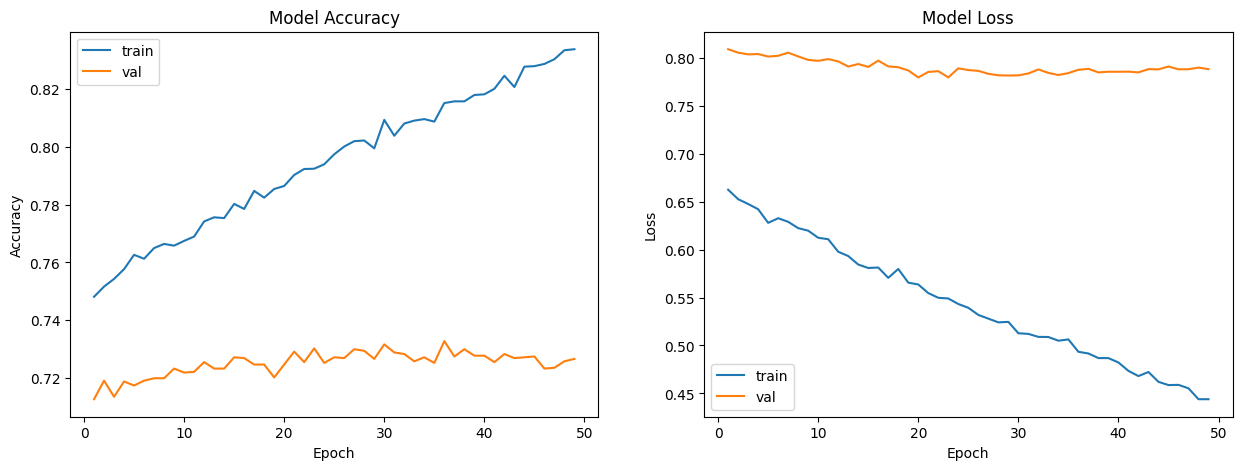

In [12]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/last.h5',
                              save_best_only=False,
                              save_weights_only=False,
                              monitor='val_accuracy'
                              )



history = model.fit(
    train_generator,
    shuffle=True,
    #use_multiprocessing=True,
    #epochs=300,
    epochs=49,
    validation_data=test_generator,
    callbacks=[rlrop,
               checkpoint]
    #callbacks=[early_stopping]
)

model.save('/content/drive/MyDrive/complete.h5')
plot_model_history(history)
tf.keras.backend.clear_session()

In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('complete.h5')

labels = (validation_generator.labels)
predictions = model.predict(validation_generator)
prediction_classes = np.argmax(predictions, axis=1)

2023-08-31 00:34:37.470925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 25s 869ms/step


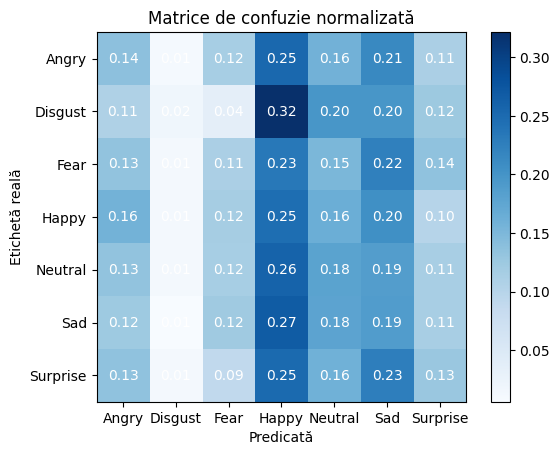

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculați matricea de confuzie
confusion_matrix = confusion_matrix(labels, prediction_classes)

# Normalizați matricea de confuzie
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1, keepdims=True)

# Creați o vizualizare grafică a matricei de confuzie normalizate
plt.imshow(confusion_matrix_normalized, cmap='Blues')
plt.title('Matrice de confuzie normalizată')
plt.xlabel('Predicată')
plt.ylabel('Etichetă reală')
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

# Adăugați proporțiile normalizate la matrice
for i in range(confusion_matrix_normalized.shape[0]):
    for j in range(confusion_matrix_normalized.shape[1]):
        plt.text(j, i, "{:.2f}".format(confusion_matrix_normalized[i, j]), color='white', ha='center', va='center')

plt.colorbar()  # adăugați o bară de culoare pentru referință
plt.show()